# Recommender System

We will be developing a movie recommender system based upon Collaborative-filtering to predict the name of the movie based upon the reviews of the other critics having similar taste. The systesm uses two different methods for finding similairties between the critics known as Euclidean-Distance-Score and Pearson-Correlation-Score. The final reault for both the methods were almost similar. After finding the similarity between critics, it uses the weighted average method to assign higher weight to the peer interest critics. Finally, It normalizes the score by deviding it by the similarities of the critics who reviewed that movie.


#### Finding Similar DataPoint

Two ways for calculating similarity scores : 
1. Euclidean Distance Score
2. Pearson Correlation Score

<hr style="height:2px">

In [1]:
# Import Packages

from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Getting more than one output Line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# Getting the Dataset

movies= pd.read_csv("data/movies.csv") # -------- nrows=5000)
movies.head()

ratings=pd.read_csv("data/ratings.csv",usecols=['userId','movieId','rating']) # -------- nrows=1000)
ratings.head()

tags= pd.read_csv('data/tags.csv')
tags.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [6]:
# Deleting unnecessary columns [Not using the timestamp column for our analysis in the meanwhile]

del tags['timestamp']
tags.head()

,userId,movieId,tag
0,15,339,sandra 'boring' bullock
1,15,1955,dentist
2,15,7478,Cambodia
3,15,32892,Russian
4,15,34162,forgettable


In [7]:
# having a look at the columns of movies df
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


In [8]:
# having a look at the distribution of ratings in ratings df
ratings['rating'].describe(include='all')

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

rating
0.5     868
1.0    1959
1.5    1204
2.0    3130
2.5    2409
3.0    4771
3.5    3612
4.0    5141
4.5    2454
5.0    3127
Name: movieId, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B39441F278>]], dtype=object)

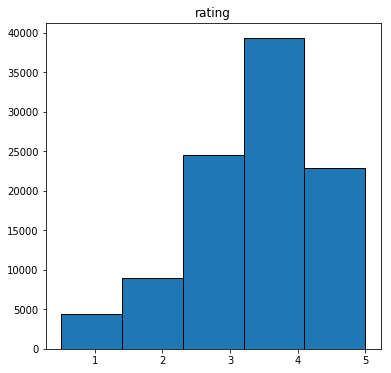

In [38]:
ratings.groupby('rating')['movieId'].nunique()
%matplotlib inline
ratings.hist(column='rating', figsize=(6,6), bins=5, grid=False, edgecolor='black')

getdvd       33
Ei muista    29
toplist07    26
tivo         26
toplist12    20
tcm          20
toplist11    20
toplist08    19
toplist15    19
toplist09    18
toplist10    18
toplist14    18
toplist06    16
funny        16
holes70s     16
Name: tag, dtype: int64

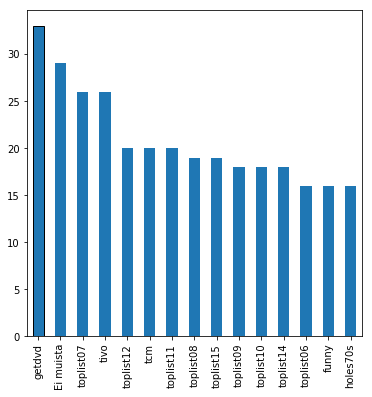

In [35]:
tag_counts = tags['tag'].value_counts()
tag_counts[:15]
tag_counts[:15].plot(kind='bar' , figsize=(6,6), edgecolor='black')

In [39]:
movies['movieId'].count()

9125

In [41]:
## Removing movies with no genre
genre_filter= (movies['genres'] == '(no genres listed)')

movies=movies[~genre_filter]

## Because removing filtered rows does not reindex the dataframe, so we have to reindex the dataframe by our own
movies=movies.reset_index(drop=True)  

In [44]:
# Checking total genres present in DataSet

genres_count= {}
for row in range(movies['movieId'].count()):
    for genre in movies['genres'][row].split("|"):
        if(genre != ''):
            genres_count[genre]= genres_count.get(genre,0)+1
        
genres_count

{'Action': 1545,
 'Adventure': 1117,
 'Animation': 447,
 'Children': 583,
 'Comedy': 3315,
 'Crime': 1100,
 'Documentary': 495,
 'Drama': 4365,
 'Fantasy': 654,
 'Film-Noir': 133,
 'Horror': 877,
 'IMAX': 153,
 'Musical': 394,
 'Mystery': 543,
 'Romance': 1545,
 'Sci-Fi': 792,
 'Thriller': 1729,
 'War': 367,
 'Western': 168}

<Container object of 19 artists>

([<matplotlib.axis.YTick at 0x1b39636f9e8>,
 <a list of 19 Text yticklabel objects>)

Text(0.5,0,'Movie Count')

Text(0.5,1,'Genre Popularty')

Text(1137,0.1,'1117')

Text(467,1.1,'447')

Text(603,2.1,'583')

Text(3335,3.1,'3315')

Text(674,4.1,'654')

Text(1565,5.1,'1545')

Text(4385,6.1,'4365')

Text(1565,7.1,'1545')

Text(1120,8.1,'1100')

Text(1749,9.1,'1729')

Text(897,10.1,'877')

Text(563,11.1,'543')

Text(812,12.1,'792')

Text(515,13.1,'495')

Text(173,14.1,'153')

Text(387,15.1,'367')

Text(414,16.1,'394')

Text(188,17.1,'168')

Text(153,18.1,'133')

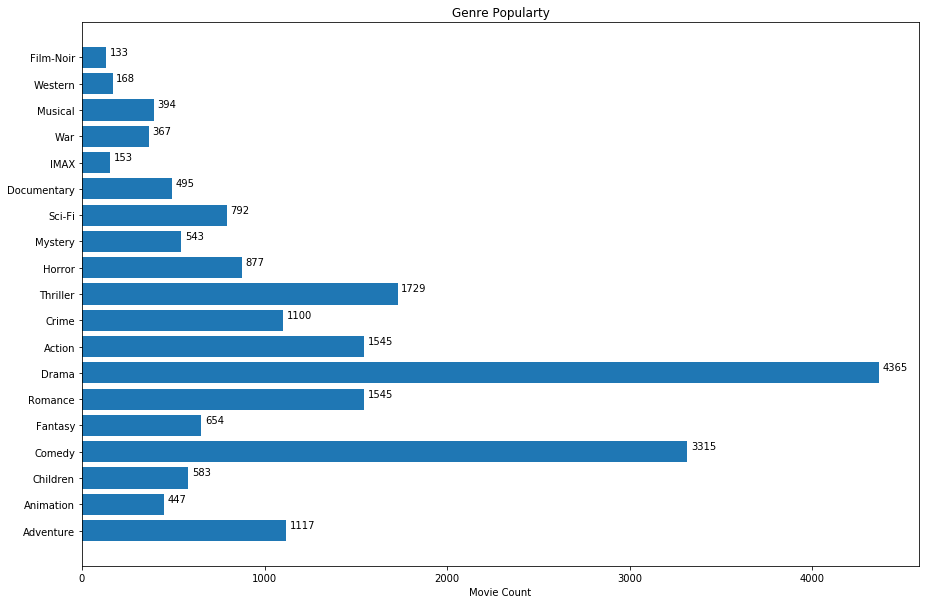

In [49]:
fig, ax = plt.subplots(figsize=(15,10))
plt.barh(range(len(genres_count)), list(genres_count.values()))
plt.yticks(range(len(genres_count)),list(genres_count.keys()))
plt.xlabel('Movie Count')
plt.title("Genre Popularty")
for i, v in enumerate(genres_count.values()):
    ax.text(v + 20, i + .10, v)

##### Observations:

There are high number of movies from genre Drama & Comedy. So, they might create abias toward the movies which are from these genres.

Film-noir & IMAX are the least popular category for films

## Euclidean Distance Score

** Euclidean Distance is the square root of the sum of squared differences between corresponding elements of the two vectors.

* Euclidean distance is only appropriate for data measured on the same scale.

* Distance = 1/(1+sqrt of sum of squares between two points)
 
* Value varies between 0 to 1, where closeness to 1 implies higher similarity.

In [55]:
# Defining a function to calculate the Euclidean Distance between two points

def euclidean_distance(person1,person2):
    #Getting details of person1 and person2
    df_first= ratings.loc[ratings['userId']==person1]
    df_second= ratings.loc[ratings.userId==person2]
    
    #Finding Similar Movies for person1 & person2 
    df= pd.merge(df_first,df_second,how='inner',on='movieId')
    
    #If no similar movie found, return 0 (No Similarity)
    if(len(df)==0): return 0
    
    #sum of squared difference between ratings
    sum_of_squares=sum(pow((df['rating_x']-df['rating_y']),2))
    return 1/(1+sum_of_squares)
    
# Check whether this function works by passing similar ID, the Corerelation should be 1
euclidean_distance(3,3) 

1.0

## Pearson Correlation Score 

* Correlation between sets of data is a measure of how well they are related. It shows the linear relationship between two sets of data. In simple terms, it answers the question, Can I draw a line graph to represent the data?


* Value varies between -1 to 1.[ 0-> Not related ; -1 -> perfect negatively corelated ; 1-> perfect positively corelated] 



* Slightly better than Euclidean because it addresses the the situation where the data isn't normalised. Like a User is giving high movie ratings in comparison to AVERAGE user.

In [56]:
# Defining a function to calculate the Pearson Correlation Score between two points

def pearson_score(person1,person2):
    
    #Get detail for Person1 and Person2
    df_first= ratings.loc[ratings.userId==person1]
    df_second= ratings.loc[ratings.userId==person2]
    
    # Getting mutually rated items    
    df= pd.merge(df_first,df_second,how='inner',on='movieId')
    
    # If no rating in common
    n=len(df)
    if n==0: return 0

    #Adding up all the ratings
    sum1=sum(df['rating_x'])
    sum2=sum(df['rating_y'])
    
    ##Summing up squares of ratings
    sum1_square= sum(pow(df['rating_x'],2))
    sum2_square= sum(pow(df['rating_y'],2))
    
    # sum of products
    product_sum= sum(df['rating_x']*df['rating_y'])
    
    ## Calculating Pearson Score
    numerator= product_sum - (sum1*sum2/n)
    denominator=sqrt((sum1_square- pow(sum1,2)/n) * (sum2_square - pow(sum2,2)/n))
    if denominator==0: return 0
    
    r=numerator/denominator
    
    return r

#Checking function by passing similar ID, Output should be 1
pearson_score(1,1)

1.0

## Getting the results based on Pearson Score

In [57]:
# Returns the best matches for person from the prefs dictionary.
# Number of results and similarity function are optional params.
def topMatches(personId,n=5,similarity=pearson_score):
    scores=[(similarity(personId,other),other) for other in ratings.loc[ratings['userId']!=personId]['userId']]
    # Sort the list so the highest scores appear at the top
    scores.sort( )
    scores.reverse( )
    return scores[0:n]

topMatches(1,n=3) ## Getting 3 most similar Users for Example 

[(1.0000000000000027, 177),
 (1.0000000000000027, 177),
 (1.0000000000000027, 177)]

## Getting Recommendations

In [73]:
# Gets recommendations for a person by using a weighted average of every other user's rankings
# Defining a function to get the recommendations

def getRecommendation(personId, similarity=pearson_score):
    '''
    totals: Dictionary containing sum of product of Movie Ratings by other user multiplied by weight(similarity)
    simSums: Dictionary containung sum of weights for all the users who have rated that particular movie.
    '''
    totals,simSums= {},{}
    
    df_person= ratings.loc[ratings.userId==personId]
    
    for otherId in ratings.loc[ratings['userId']!=personId]['userId']: # all the UserID except personID
        
        # Getting Similarity with OtherID
        sim=similarity(personId,otherId)
        
        # Ignores Score of Zero or Negatie correlation         
        if sim<=0: continue
            
        df_other=ratings.loc[ratings.userId==otherId]
        
        #Movies not seen by the personID
        movie=df_other[~df_other.isin(df_person).all(1)]
        
        for movieid,rating in (np.array(movie[['movieId','rating']])):
            #similarity* Score
            totals.setdefault(movieid,0)
            totals[movieid]+=rating*sim
            
            #Sum of Similarities
            simSums.setdefault(movieid,0)
            simSums[movieid]+=sim
            
        
        
        
        # Creating Normalized List
        ranking=[(t/simSums[item],item) for item,t in totals.items()]
        
        # return the sorted List
        ranking.sort()
        ranking.reverse()
        recommendedId=np.array([x[1] for x in ranking])
        
        
        return list(np.array(movies[movies['movieId'].isin(recommendedId)]['title'])[:20])

In [97]:
### Example Recommendation
# Returns 20 recommended movie for the given UserID
# userId can be ranged from 1 to 671

# taking the User_Id as input and recommending movies for the user

user_id = int(input("Enter Your UserId: "))

recommended_movies = getRecommendation(user_id)
print("____________________________________________________")
print("\n Recommended Movies: User {}".format(user_id))
print("____________________________________________________")
print(*recommended_movies, sep='\n')
print("____________________________________________________")

Enter Your UserId: 143
____________________________________________________

 Recommended Movies: User 143
____________________________________________________
GoldenEye (1995)
Sense and Sensibility (1995)
Clueless (1995)
Seven (a.k.a. Se7en) (1995)
Usual Suspects, The (1995)
Mighty Aphrodite (1995)
Mr. Holland's Opus (1995)
Braveheart (1995)
Brothers McMullen, The (1995)
Apollo 13 (1995)
Batman Forever (1995)
Crimson Tide (1995)
Die Hard: With a Vengeance (1995)
First Knight (1995)
Net, The (1995)
Nine Months (1995)
Waterworld (1995)
Circle of Friends (1995)
Clerks (1994)
Disclosure (1994)
____________________________________________________
